In [1]:
import numpy as np
import visualkeras as vk 

from keras import Model
from keras.models import load_model
from keras.optimizers import gradient_descent_v2
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import Callback

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Conv2DTranspose, concatenate
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.utils import shuffle

train_data = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/X_train_char.npy")
test_data = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/X_test_char.npy")
train_labels = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/y_train_char.npy")
test_labels = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/y_test_char.npy")

# Normalization 

train_data = train_data / 255.0
test_data = test_data / 255.0

In [2]:
# Changing the old labels to row-column

train_labels_row = []
train_labels_col = []

for label in train_labels:
    row, col = divmod(label, 7)
    train_labels_row.append(row)
    train_labels_col.append(col)

train_labels_row = np_utils.to_categorical(train_labels_row)
train_labels_col = np_utils.to_categorical(train_labels_col)


In [3]:
test_labels_row = []
test_labels_col = []

for label in test_labels:
    row, col = divmod(label, 7)
    test_labels_row.append(row)
    test_labels_col.append(col)

test_labels_row = np_utils.to_categorical(test_labels_row)
test_labels_col = np_utils.to_categorical(test_labels_col)

In [4]:
print(train_labels_row.shape, train_labels_col.shape, test_labels_row.shape, test_labels_col.shape, sep='\n')

(70194, 33)
(70194, 7)
(7800, 33)
(7800, 7)


In [5]:
# Model

# feature extraction UNET

input = Input(train_data.shape[1:])

conv1 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (input)
conv1 = MaxPool2D(pool_size=2, strides=2) (conv1)

conv2 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
conv2 = MaxPool2D(pool_size=2, strides=2) (conv2)

conv3 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
conv3 = MaxPool2D(pool_size=2, strides=2) (conv3)

# classification multi-task learing CNN 

flatten = Flatten() (conv3)
fc1 = Dense(128, activation='relu') (flatten)
fc2 = Dense(256, activation='relu') (fc1)                   # neurons?

row = Dense(units=33, activation='softmax', name='row') (fc2)
col = Dense(units=7, activation='softmax', name='col') (fc2)

model = Model(inputs=input, outputs=[row, col], name='FCNN')

model.compile(
    optimizer=gradient_descent_v2.SGD(momentum=0.9,), # 'adam'
    loss=[
        'categorical_crossentropy', 
        'categorical_crossentropy'  
    ], 
    loss_weights = None,
    metrics=['accuracy']
) 

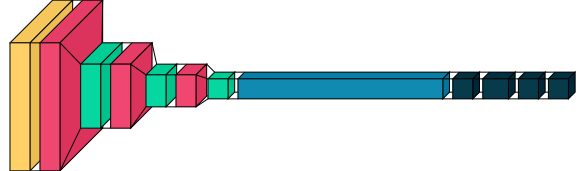

In [6]:
vk.layered_view(model)

In [8]:
class CombinedMetric(Callback):
    def __init__(self):
        super(CombinedMetric, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        logs['accuracy'] = (logs["row_accuracy"] + logs["col_accuracy"]) / 2
        logs['val_accuracy'] = (logs["val_row_accuracy"] + logs["val_col_accuracy"]) / 2

In [9]:
callbacks = [
    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/belay-fcnn-arct/best_loss_model.h5",
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min"
    ),

    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/belay-fcnn-arct/best_val_loss_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False, 
        mode="min"
    ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10
    ),

    TensorBoard(
        log_dir="../datasets/Amharic character Image dataset/models/belay-fcnn-arct"
    ),

    CombinedMetric()
]

In [10]:
history = model.fit(
    train_data,
    [train_labels_row, train_labels_col],
    validation_data=(test_data, [test_labels_row,test_labels_col]), 
    epochs=100, 
    batch_size=150, 
    callbacks=[callbacks]
)

Epoch 1/100
468/468 [==============================] - 22s 13ms/step - loss: 1.8305 - row_loss: 1.0310 - col_loss: 0.7995 - row_accuracy: 0.7316 - col_accuracy: 0.7122 - val_loss: 0.6148 - val_row_loss: 0.2920 - val_col_loss: 0.3229 - val_row_accuracy: 0.9265 - val_col_accuracy: 0.9101 - accuracy: 0.7219 - val_accuracy: 0.9183
Epoch 2/100
468/468 [==============================] - 6s 13ms/step - loss: 0.4975 - row_loss: 0.2390 - col_loss: 0.2585 - row_accuracy: 0.9381 - col_accuracy: 0.9247 - val_loss: 0.4760 - val_row_loss: 0.2181 - val_col_loss: 0.2578 - val_row_accuracy: 0.9432 - val_col_accuracy: 0.9265 - accuracy: 0.9314 - val_accuracy: 0.9349
Epoch 3/100
468/468 [==============================] - 6s 13ms/step - loss: 0.3758 - row_loss: 0.1809 - col_loss: 0.1950 - row_accuracy: 0.9508 - col_accuracy: 0.9416 - val_loss: 0.3883 - val_row_loss: 0.1776 - val_col_loss: 0.2107 - val_row_accuracy: 0.9549 - val_col_accuracy: 0.9401 - accuracy: 0.9462 - val_accuracy: 0.9475
Epoch 4/100
468

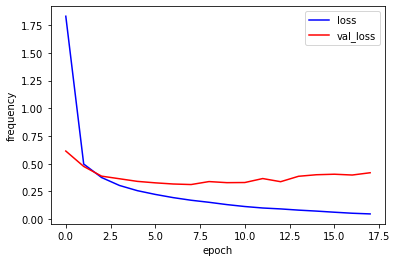

In [11]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

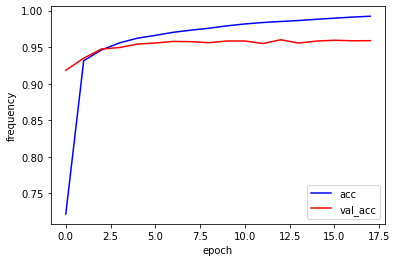

In [12]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [14]:
model = load_model("../datasets/Amharic character Image dataset/models/belay-fcnn-arct/best_val_loss_model.h5")

loss, _, _, row_acc, col_acc = model.evaluate(test_data, [test_labels_row,test_labels_col], verbose=False)

print('row_accuracy: {:5.4f}%'.format(100 * row_acc))
print('col_accuracy: {:5.4f}%'.format(100 * col_acc))
print()
print('accuracy: {:5.4f}%'.format(100 * (row_acc + col_acc)/2))
print('val_loss: {:5.4f}%'.format(100 * loss))

row_accuracy: 96.3718%
col_accuracy: 95.1154%

accuracy: 95.7436%
val_loss: 31.2623%


In [16]:
pred_row, pred_col, pred_char, mispred = 0,0,0,0

for i in range(len(test_data)):
    test_image = np.reshape(test_data[i], (1,32,32,1))
    row_pred, col_pred = model.predict(test_image)
    if (np.argmax(row_pred) ==  np.argmax(test_labels_row[i]) and np.argmax(col_pred) ==  np.argmax(test_labels_col[i])):
        pred_char += 1
    elif (np.argmax(row_pred) ==  np.argmax(test_labels_row[i])):
        pred_row += 1
    elif (np.argmax(col_pred) ==  np.argmax(test_labels_col[i])):
        pred_col += 1
    elif (np.argmax(row_pred) !=  np.argmax(test_labels_row[i]) and np.argmax(col_pred) !=  np.argmax(test_labels_col[i])):
        mispred += 1
    else:
        pass

In [17]:
print('row_accuracy: {:5.4f}%'.format(100 * (pred_row + pred_char) / len(test_data)))
print('col_accuracy: {:5.4f}%'.format(100 * (pred_col + pred_char) / len(test_data)), '\n')

print('overall accuracy: {:5.4f}%'.format(100 * (pred_char) / len(test_data)))
print('val_loss: {:5.4f}%'.format(100 * loss))

row_accuracy: 96.3718%
col_accuracy: 95.1154% 

overall accuracy: 92.9744%
val_loss: 31.2623%
